InvalidArgumentError: h1_input_4:0 is both fed and fetched.

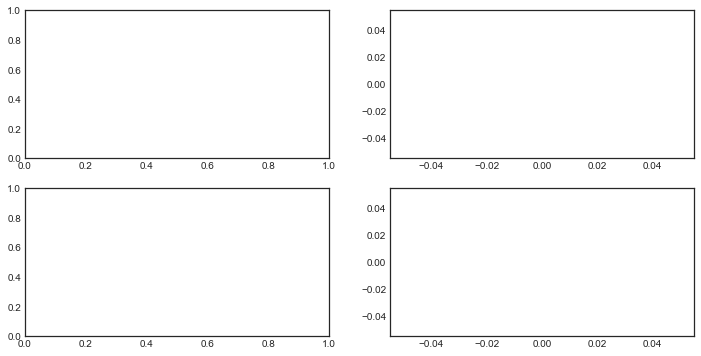

In [3]:
from keras.initializers import normal, glorot_normal, glorot_uniform, he_normal, he_uniform
from keras.layers import Dense
from keras.models import Sequential

from deepreplay.callbacks import ReplayData
from deepreplay.datasets.ball import load_data
from deepreplay.plot import compose_plots
from deepreplay.replay import Replay

from matplotlib import pyplot as plt

# Model builder function
def build_model(n_layers, input_dim, units, activation, initializer):
    if isinstance(units, list):
        assert len(units) == n_layers
    else:
        units = [units] * n_layers

    model = Sequential()
    # Adds first hidden layer with input_dim parameter
    model.add(Dense(units=units[0], input_dim=input_dim, activation=activation, kernel_initializer=initializer, name='h1'))

    # Adds remaining hidden layers
    for i in range(2, n_layers + 1):
        model.add(Dense(units=units[i-1], activation=activation, kernel_initializer=initializer, name='h{}'.format(i)))

    # Adds output layer
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer=initializer, name='o'))
    # Compiles the model
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])
    return model

X, y = load_data(n_dims=10)

filename = 'part2_weight_initializers.h5'

# Examples of different initializers

# Uses normal initializer
# activation = 'sigmoid'
# initializer = normal(mean=0, stddev=0.01, seed=13)
# title = r'Activation: sigmoid - Initializer: $\sigma = 0.01$'
# group_name = 'sigmoid_stdev_0.01'

# Users Glorot Uniform
# activation = 'tanh'
# initializer = glorot_uniform(seed=13)
# title = 'Activation: Tanh - Initializer: Glorot Uniform'
# group_name = 'tanh_glorot_uniform'

# Uses He Uniform
activation = 'relu'
initializer = he_uniform(seed=13)
title = 'Activation: ReLU - Initializer: He Uniform'
group_name = 'relu_he_uniform'

# Builds BLOCK model
model = build_model(n_layers=5, input_dim=10, units=100, activation=activation, initializer=initializer)

# Since we only need initial weights, we don't even need to train the model!
# We still use the ReplayData callback, but we can pass the model as argument instead
replaydata = ReplayData(X, y, filename=filename, group_name=group_name, model=model)

# Now we feed the data to the actual Replay object so we can build the visualizations
replay = Replay(replay_filename=filename, group_name=group_name)

# Using subplot2grid to assemble a complex figure...
fig = plt.figure(figsize=(12, 6))
ax_zvalues = plt.subplot2grid((2, 2), (0, 0))
ax_weights = plt.subplot2grid((2, 2), (0, 1))
ax_activations = plt.subplot2grid((2, 2), (1, 0))
ax_gradients = plt.subplot2grid((2, 2), (1, 1))

wv = replay.build_weights(ax_weights)
gv = replay.build_gradients(ax_gradients)
# Z-values
zv = replay.build_outputs(ax_zvalues, before_activation=True, exclude_outputs=True, include_inputs=False)
# Activations
av = replay.build_outputs(ax_activations, exclude_outputs=True, include_inputs=False)

# Finally, we use compose_plots to update all
# visualizations at once
fig = compose_plots([zv, wv, av, gv], epoch=0, title=title)
fig.savefig('part2.png', format='png', dpi=120)